In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook 

from utils import mlp,train_test_model
from utils.mas_utils.mas import MAS
from utils.mas_utils.sketchMAS import SketchMAS

from data.permuted_MNIST import get_permuted_mnist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os

results_folder='perm_mnist_test/'
models_folder='saved_models/'

if not os.path.isdir(results_folder):
    os.mkdir(results_folder)
if not os.path.isdir(models_folder):
    os.mkdir(models_folder)

## Set configurations

In [4]:
epochs = 20
lr = 1e-4 
batch_size = 100 
input_size = 784
hidden_sizes = [1024,512,256]
output_size = 10

num_task = 5
n_bucket = 10

activation='ReLU'
device='cuda:0'

## Load dataset

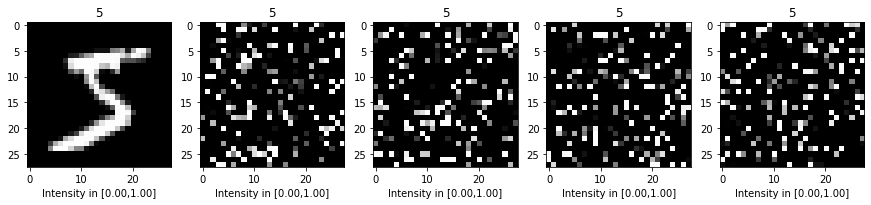

In [5]:
train_loader, test_loader = get_permuted_mnist(num_task,batch_size)

fig,ax=plt.subplots(1,num_task,figsize=(num_task*3,3))
for i in range(num_task):
    iter_data=iter(train_loader[i])
    image,label=iter_data.next()
    I=np.reshape(image.data[0,...].numpy(),(28,28))    
    ax[i].imshow(I,cmap='gray')
    ax[i].set_title(label.data[0].numpy())
    ax[i].set_xlabel("Intensity in [%.2f,%.2f]"%(I.min(),I.max()))
plt.show()

## First we perform sequential learning with standard MLP 

In [6]:
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)

## Perform training
loss, acc = {}, {}
for task in tqdm_notebook(range(num_task)):
    loss[task] = []
    acc[task] = []
    for _ in tqdm_notebook(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss[task].append(train_test_model.train_classifier(model=model,
                                                            optimizer=optimizer,
                                                            data_loader=train_loader[task],
                                                            device=device))            
        for sub_task in range(task + 1):
            acc[sub_task].append(train_test_model.test_classifier(model=model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))
            
    torch.save(model.state_dict(), models_folder + 'model_standard_'+str(task)+'.pt') 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0.98, 'Catastrophic forgetting')

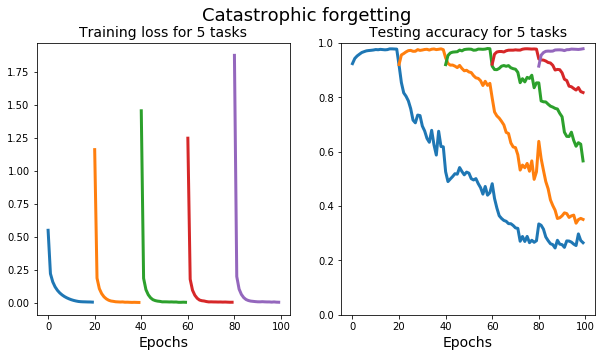

In [7]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for %d tasks'%(num_task),fontsize=14)
for t, v in acc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for %d tasks'%(num_task),fontsize=14)
fig.suptitle('Catastrophic forgetting',fontsize=18)

## Next we perform MAS

In [8]:
mas_iteration = 1
mas_alpha=0.25
mas_importance=2e+4
loss_mas_list = []
acc_mas_list = []

In [10]:
for i in tqdm_notebook(range(mas_iteration)):
    ## define a MLP model
    model = mlp.MLP(input_size=input_size,output_size=output_size,
                  hidden_size=hidden_sizes,activation=activation,
                  device=device).to(device)
    mas = MAS(model,device=device,alpha=mas_alpha)
    ## performing training
    loss_mas, acc_mas = {}, {}
    for task in tqdm_notebook(range(num_task)):
        loss_mas[task] = []
        acc_mas[task] = []
        for _ in range(epochs):
            optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
            loss_mas[task].append(train_test_model.mas_train_classifier(mas=mas,
                                                                        optimizer=optimizer,
                                                                        data_loader=train_loader[task],
                                                                        importance=mas_importance,
                                                                        device=device))                           
            for sub_task in range(task + 1):
                acc_mas[sub_task].append(train_test_model.test_classifier(model=mas.model,
                                                                        data_loader=test_loader[sub_task],
                                                                         device=device))
        mas.consolidate(train_loader[task])    
        torch.save(mas.model.state_dict(), models_folder + 'model_mas_'+str(task)+'.pt') 

    loss_mas_list.append(loss_mas)
    acc_mas_list.append(acc_mas)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Text(0.5, 0.98, 'Using MAS Regularizer')

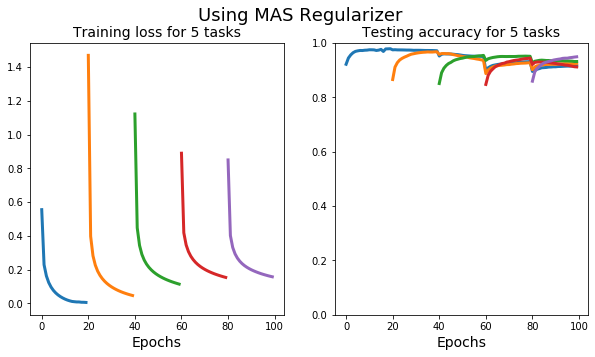

In [11]:
i=0
loss_mas = loss_mas_list[i]
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_mas.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for %d tasks'%(num_task),fontsize=14)
for t, v in acc_mas.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for %d tasks'%(num_task),fontsize=14)
fig.suptitle('Using MAS Regularizer',fontsize=18)

## Next we perform CountSketch (on MAS)

In [37]:
sketch_mas_iteration = 2
sketch_mas_alpha = 0.5
sketch_mas_importance_list = [100,300]
n_bucket_list = [50, 50]
# loss_sketch_mas_list = []
# acc_sketch_mas_list = []

In [38]:
for i in tqdm_notebook(range(sketch_mas_iteration)):
    sketch_mas_importance = sketch_mas_importance_list[i]
    n_bucket = n_bucket_list[i]
    ## define a MLP model
    model=mlp.MLP(input_size=input_size,output_size=output_size,
                  hidden_size=hidden_sizes,activation=activation,
                  device=device).to(device)
    sketch_mas = SketchMAS(model,device=device,alpha=sketch_mas_alpha,n_bucket=n_bucket)
    ## performing training
    loss_sketch_mas, acc_sketch_mas = {}, {}
    for task in tqdm_notebook(range(num_task)):
        loss_sketch_mas[task] = []
        acc_sketch_mas[task] = []
        for _ in range(epochs):
            optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
            loss_sketch_mas[task].append(train_test_model.mas_train_classifier(mas=sketch_mas,
                                                                        optimizer=optimizer,
                                                                        data_loader=train_loader[task],
                                                                        importance=sketch_mas_importance,
                                                                        device=device))
            for sub_task in range(task + 1):
                acc_sketch_mas[sub_task].append(train_test_model.test_classifier(model=sketch_mas.model,
                                                                         data_loader=test_loader[sub_task],
                                                                         device=device))
        sketch_mas.consolidate(train_loader[task])
    loss_sketch_mas_list.append(loss_sketch_mas)
    acc_sketch_mas_list.append(acc_sketch_mas)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0.98, 'Using CountSketch on MAS')

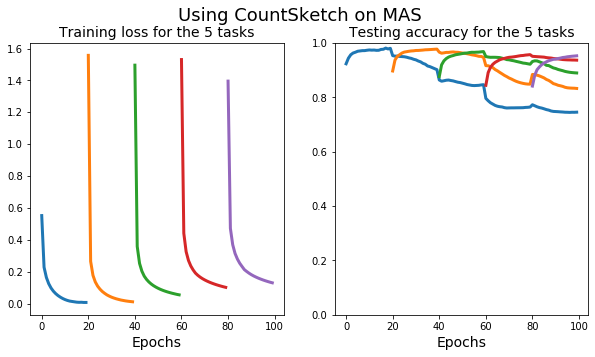

In [51]:
i=6
loss_sketch_mas = loss_sketch_mas_list[i]
acc_sketch_mas = acc_sketch_mas_list[i]
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_sketch_mas.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the %d tasks'%(num_task),fontsize=14)
for t, v in acc_sketch_mas.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the %d tasks'%(num_task),fontsize=14)
fig.suptitle('Using CountSketch on MAS',fontsize=18)

In [33]:
def get_mean_acc_on_iterations(acc_list):
    acc = {}
    for i in acc_list[0].keys():
        acc[i] = np.zeros(len(acc_list[0][i]))
    for t in range(len(acc_list)):
        for i in acc_list[0].keys():
            acc[i] += np.array(acc_list[t][i]) / len(acc_list)
    return acc

In [61]:
acc_mas = get_mean_acc_on_iterations(acc_mas_list)
acc_sketch_mas = get_mean_acc_on_iterations(acc_sketch_mas_list)

In [35]:
def get_mean_acc(acc,epochs):
    num_task=len(acc)
    temp=np.zeros((num_task,len(acc[0])))
    for t,v in acc.items():
        temp[t,range(t * epochs, num_task * epochs)]=v
        if t<num_task-1:
            temp[t+1,:]=temp[:t+1,:].mean(0)
    return temp.mean(0)

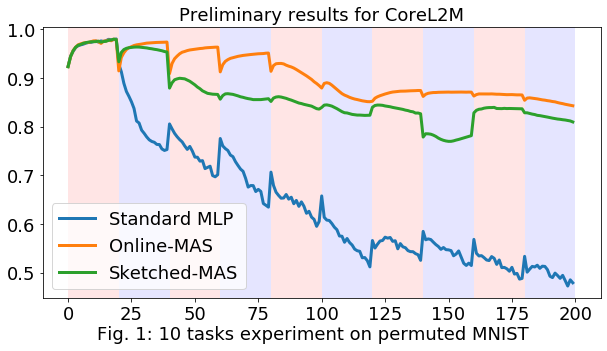

In [62]:
plt.figure(figsize=(10,5))
for t in range(num_task):
    if t%2:
        c='b'
    else:
        c='r'
    plt.axvspan(t*epochs, (t+1)*epochs, facecolor=c, alpha=0.1)
plt.plot(get_mean_acc(acc,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_mas,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_sketch_mas,epochs),linewidth=3)
plt.xticks(fontsize=18),plt.yticks(fontsize=18)
plt.legend(['Standard MLP','Online-MAS','Sketched-MAS'],fontsize=18)
plt.title('Preliminary results for CoreL2M',fontsize=18)
plt.figtext(0.5, 0.01, 'Fig. 1: 10 tasks experiment on permuted MNIST', wrap=True, horizontalalignment='center', fontsize=18)
plt.show()


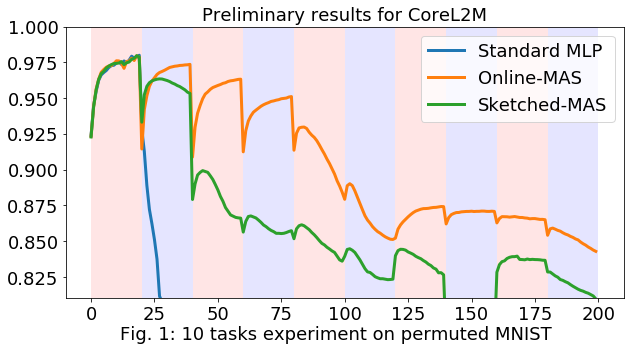

In [63]:
plt.figure(figsize=(10,5))
for t in range(num_task):
    if t%2:
        c='b'
    else:
        c='r'
    plt.axvspan(t*epochs, (t+1)*epochs, facecolor=c, alpha=0.1)
plt.plot(get_mean_acc(acc,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_mas,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_sketch_mas,epochs),linewidth=3)
plt.ylim(.81,1.) 
plt.xticks(fontsize=18),plt.yticks(fontsize=18)
plt.legend(['Standard MLP','Online-MAS','Sketched-MAS'],fontsize=18)
plt.title('Preliminary results for CoreL2M',fontsize=18)
plt.figtext(0.5, 0.01, 'Fig. 1: 10 tasks experiment on permuted MNIST', wrap=True, horizontalalignment='center', fontsize=18)
plt.show()


In [ ]:
import pickle
iteration=0
pickle.dump([[loss,loss_mas,loss_sketch_mas],
                 [acc,acc_mas,acc_sketch_mas]],
                 open(results_folder+'experiment_%d.pkl'%iteration,'wb'))